In [1]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

import pandas as pd
import numpy as np
import keras
from keras.utils.data_utils import get_file
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from os.path import join
import multiprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_HOME = '/ext_drive/liyin/webface-full-aligned-with-32-margin-resized/'

In [3]:
dataset = pd.read_csv('webface-full.aligned.train.csv', nrows=None)

In [4]:
encoder = LabelEncoder()
encoder.fit(dataset['person'])
dataset['person_id'] = encoder.transform(dataset['person'])

In [5]:
dataset.head()

,person,count,path,person_id
0,3331486,12,3331486/007.png,9650
1,3331486,12,3331486/002.png,9650
2,3331486,12,3331486/008.png,9650
3,3331486,12,3331486/006.png,9650
4,3331486,12,3331486/012.png,9650


In [6]:
np.mean(dataset.groupby('person_id')['person'].count())

42.87602836879432

In [7]:
# if the count > 30, will random pick 30 + (count-30)*0.2 imgs for the person
import random
random.seed(42)

FACE_NUM = 45

def crit(idx):
    row = dataset.ix[idx]
    count = row['count']
    if count < FACE_NUM: return True
    ratio = (FACE_NUM+(count-FACE_NUM)*0.4) / count
    return random.random() < ratio

def crit2(idx):
    row = dataset.ix[idx]
    count = row['count']
    if count < 6: return True
    return False
    
# dataset = dataset.select(crit)
dataset = pd.concat([dataset, dataset.select(crit2)], axis=0).reset_index()

In [8]:
np.mean(dataset.groupby('person_id')['person'].count())

42.881513002364066

In [9]:
y = dataset['person_id'].as_matrix()

In [10]:
# y = np.concatenate([y,y])
y.shape

(453472,)

In [11]:
img_paths = [r.path for r in dataset.itertuples()]
print(len(img_paths))

453472


In [12]:
img_paths[0]

'3331486/007.png'

In [13]:
from PIL import Image

def path2ImgVec(path):
    x = img_to_array(load_img(join(DATA_HOME, path)))
#     x = img_to_array(load_img(join(DATA_HOME, path)).convert('L'))
    return x.reshape((1,) + x.shape)

def path2ImgVecFlipped(path):
    img = load_img(join(DATA_HOME, path)).convert('L')
    img = img.transpose(Image.FLIP_LEFT_RIGHT)
    x = img_to_array(img)
    return x.reshape((1,) + x.shape)

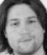

In [14]:
load_img(join(DATA_HOME, img_paths[0])).convert('L')

In [15]:
pool = multiprocessing.Pool(8)
results1 = pool.map(path2ImgVec, img_paths)
pool.close()
pool.join()
del pool

In [16]:
# pool = multiprocessing.Pool(8)
# results2 = pool.map(path2ImgVecFlipped, img_paths)
# pool.close()
# pool.join()
# del pool

In [17]:
X = np.vstack(results1)
# X = np.vstack(results1+results2)

In [18]:
X.shape

(453472, 55, 47, 3)

In [19]:
for i in range(len(results1)): 
    results1[i] = None
del results1

In [20]:
# for i in range(len(results2)): 
#     results2[i] = None
# del results2

In [21]:
nb_class = len(np.unique(y))
print('nb_class', nb_class)
hidden_dim = 160
best_weights_filepath = '../models/best_weights.hdf5'
input_shape = X.shape[1:]

nb_class 10575


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

In [23]:
del X, y

In [24]:
import gc
gc.collect()

100

In [25]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, Input, concatenate
from keras.utils import np_utils
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score
from keras import metrics
from keras.callbacks import Callback
from keras.layers.normalization import BatchNormalization
from keras.engine import Model
from keras import optimizers

def build_model():
    image_input = Input(shape=input_shape)
    
    conv1 = Conv2D(20, (4, 4), name='conv1')(image_input)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), name='pool1')(conv1)
#     pool1 = Dropout(rate=0.2)(pool1)
    
    conv2 = Conv2D(40, (3, 3), name='conv2')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), name='pool2')(conv2)
#     pool2 = Dropout(rate=0.2)(pool2)

    conv3 = Conv2D(60, (3, 3), name='conv3')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), name='pool3')(conv3)

    flat1 = Flatten(name='flat1')(pool3)
    
    conv4 = Conv2D(80, (2, 2), name='conv4')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    flat2 = Flatten(name='flat2')(conv4)
    
    merged = concatenate([flat1, flat2])
    
    out = Dense(hidden_dim, name='hidden1')(merged)
    out = BatchNormalization()(out)
    out = Activation('relu',name='deepid')(out)
    out = Dense(nb_class, activation='softmax', name='softmax_class')(out)
    
    model = Model(inputs=image_input, outputs=out)

    # optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0001)

    model.compile(
        optimizer='adam', #rmsprop
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )
    
    print(model.summary())
    return model

In [44]:
model = None
# with tf.device('/gpu:0'):
model = build_model()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 55, 47, 3)     0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 52, 44, 20)    980                                          
____________________________________________________________________________________________________
batch_normalization_16 (BatchNor (None, 52, 44, 20)    80                                           
____________________________________________________________________________________________________
activation_13 (Activation)       (None, 52, 44, 20)    0                                            
___________________________________________________________________________________________

In [45]:
saveBestModel = keras.callbacks.ModelCheckpoint(
    best_weights_filepath, 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    mode='auto'
)
earlyStopping=keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=1, 
    mode='auto'
)

history2048 = model.fit(
    X_train, 
    y_train, 
    batch_size=2048, 
    epochs=20, #8
    verbose=2, 
    validation_split=0.1, 
    shuffle=True,
    callbacks=[saveBestModel, earlyStopping],
)

Train on 367311 samples, validate on 40813 samples
Epoch 1/20
68s - loss: 8.1360 - acc: 0.0188 - val_loss: 7.9941 - val_acc: 0.0155
Epoch 2/20
68s - loss: 6.5441 - acc: 0.0908 - val_loss: 6.6397 - val_acc: 0.0638
Epoch 3/20
69s - loss: 5.2157 - acc: 0.2016 - val_loss: 5.1764 - val_acc: 0.2069
Epoch 4/20
69s - loss: 4.1698 - acc: 0.3269 - val_loss: 4.6111 - val_acc: 0.2783
Epoch 5/20
69s - loss: 3.4197 - acc: 0.4302 - val_loss: 4.2191 - val_acc: 0.3331
Epoch 6/20
69s - loss: 2.8871 - acc: 0.5074 - val_loss: 3.8952 - val_acc: 0.3884
Epoch 7/20
69s - loss: 2.5025 - acc: 0.5658 - val_loss: 3.8311 - val_acc: 0.3969
Epoch 8/20
69s - loss: 2.2053 - acc: 0.6118 - val_loss: 3.7433 - val_acc: 0.4129
Epoch 9/20
69s - loss: 1.9692 - acc: 0.6484 - val_loss: 3.9736 - val_acc: 0.3888
Epoch 10/20
86s - loss: 1.7724 - acc: 0.6797 - val_loss: 3.8246 - val_acc: 0.4137
Epoch 11/20
118s - loss: 1.6006 - acc: 0.7086 - val_loss: 3.6815 - val_acc: 0.4412
Epoch 12/20
118s - loss: 1.4542 - acc: 0.7328 - val_los

In [ ]:
history

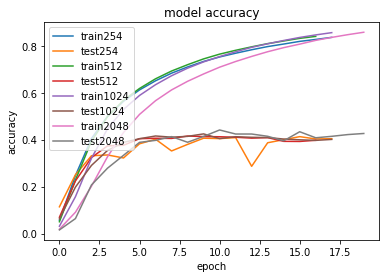

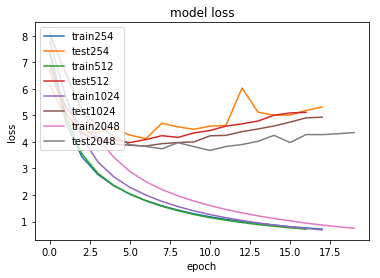

In [47]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history254.history['acc'])
plt.plot(history254.history['val_acc'])
plt.plot(history512.history['acc'])
plt.plot(history512.history['val_acc'])
plt.plot(history1024.history['acc'])
plt.plot(history1024.history['val_acc'])
plt.plot(history2048.history['acc'])
plt.plot(history2048.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train254', 'test254', 'train512', 'test512', 'train1024', 'test1024', 'train2048', 'test2048'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history254.history['loss'])
plt.plot(history254.history['val_loss'])
plt.plot(history512.history['loss'])
plt.plot(history512.history['val_loss'])
plt.plot(history1024.history['loss'])
plt.plot(history1024.history['val_loss'])
plt.plot(history2048.history['loss'])
plt.plot(history2048.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train254', 'test254', 'train512', 'test512', 'train1024', 'test1024', 'train2048', 'test2048'], loc='upper left')
plt.show()

In [28]:
# model.load_weights(best_weights_filepath)

In [29]:
# model.save('../models/webface-full-simple-cnn.aligned.margin32.1.s20.model.h5')

In [30]:
# model.evaluate(X_test, y_test, batch_size=1024, verbose=2)

In [31]:
import gc
gc.collect()

0